In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil


dropout_rate = 0.5
fc_dropout_rate = 0.5

DATA_DIR = f'results_008_gn_lang_classification__dropout_{dropout_rate}__fc_dropout_{fc_dropout_rate}'

model_names = ['LangIdCNN_MeanStd_FCD', 'LangIdCNN_Mean2_FCD']


# DATA_DIR = 'results_008_gn_lang_classification__dropout_0.6__fc_dropout_0.5_contrastive'
# model_names = ["LangIdCNN_Mean2_FCD_Contrastive", "LangIdCNN_Mean2_FCD"]



random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if not p.suffixes or p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_MeanStd_FCD
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-z_3
	wav2vec_features-z_4
	wav2vec_features-z_5
	wav2vec_features-z_6
	wav2vec_features-z_7
	wav2vec_features-z_8
	wav2vec_features-z_9
MODEL: LangIdCNN_Mean2_FCD
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
fold_count = 10


# test_acc
# test_acc_channel_music
# test_acc_channel_noise
# test_acc_channel_telephone
# test_acc_gender_female
# test_acc_gender_male
# test_acc_language_maninka
# test_acc_language_pular
# test_acc_language_susu
# test_acc_speaker_count_multiple
# test_acc_speaker_count_single
# test_acc_utterance_multilingual
# test_acc_utterance_verbal_nod


    
#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count),
    
    ('test_acc_speaker_count_multiple', fold_count),
    ('test_acc_speaker_count_single', fold_count),
    
    
    ('test_acc_utterance_multilingual', fold_count),
    ('test_acc_utterance_verbal_nod', fold_count),
    
    
    ('test_acc_channel_music', fold_count),
    ('test_acc_channel_noise', fold_count),
    ('test_acc_channel_telephone', fold_count),
    
    ('test_n', fold_count),
    ('test_n_channel_music', fold_count),
    ('test_n_channel_noise', fold_count),
    ('test_n_channel_telephone', fold_count),
    ('test_n_gender_female', fold_count),
    ('test_n_gender_male', fold_count),
    ('test_n_language_maninka', fold_count),
    ('test_n_language_pular', fold_count),
    ('test_n_language_susu', fold_count),
    ('test_n_speaker_count_multiple', fold_count),
    ('test_n_speaker_count_single', fold_count),
    ('test_n_utterance_multilingual', fold_count),
    ('test_n_utterance_verbal_nod', fold_count),

]


# Language classification with context features

In [9]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

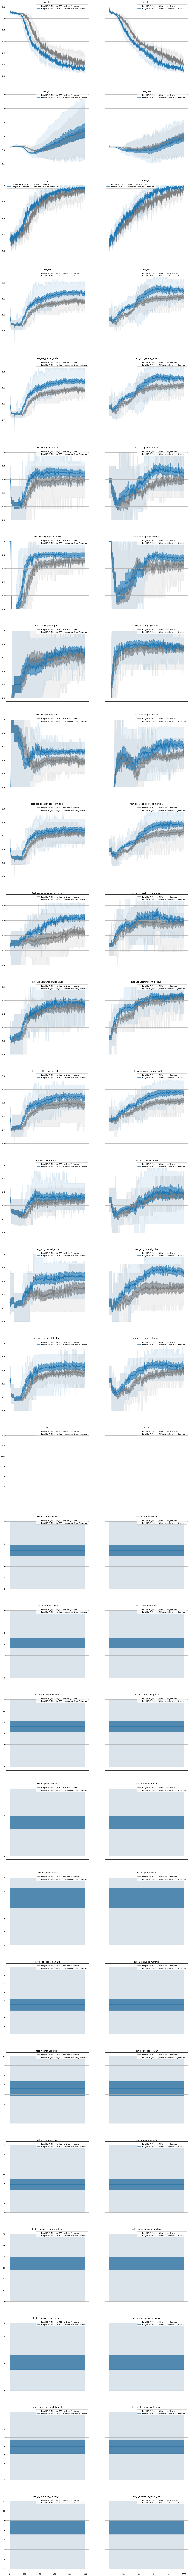

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    
    test_y_speaker_multi = (bar_width+bar_margin)*np.arange(label_count) + 9.5
    test_y_speaker_single = (bar_width+bar_margin)*np.arange(label_count) + 10.5
    
    test_y_utt_multilingual = (bar_width+bar_margin)*np.arange(label_count) + 12
    test_y_utt_verbal_nod = (bar_width+bar_margin)*np.arange(label_count) + 13
    
    test_y_channel_music = (bar_width+bar_margin)*np.arange(label_count) + 14.5
    test_y_channel_noise = (bar_width+bar_margin)*np.arange(label_count) + 15.5
    test_y_channel_telephone = (bar_width+bar_margin)*np.arange(label_count) + 16.5


    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_speaker_multi, series_means['test_acc_speaker_count_multiple'], height=1, xerr=series_sems['test_acc_speaker_count_multiple'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_speaker_single, series_means['test_acc_speaker_count_single'], height=1, xerr=series_sems['test_acc_speaker_count_single'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_utt_multilingual, series_means['test_acc_utterance_multilingual'], height=1, xerr=series_sems['test_acc_utterance_multilingual'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_utt_verbal_nod, series_means['test_acc_utterance_verbal_nod'], height=1, xerr=series_sems['test_acc_utterance_verbal_nod'], color=colors['pular'], alpha=bias_alpha)

    ax.barh(test_y_channel_music, series_means['test_acc_channel_music'], height=1, xerr=series_sems['test_acc_channel_music'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_noise, series_means['test_acc_channel_noise'], height=1, xerr=series_sems['test_acc_channel_noise'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_telephone, series_means['test_acc_channel_telephone'], height=1, xerr=series_sems['test_acc_channel_telephone'], color=colors['pular'], alpha=bias_alpha)

    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        
        ax.text(0.01, test_y_male_pos[i]-0.3, f"male ({series_means['test_n_gender_male'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, f"female ({series_means['test_n_gender_female'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, f"susu ({series_means['test_n_language_susu'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, f"maninka ({series_means['test_n_language_maninka'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, f"pular ({series_means['test_n_language_pular'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_speaker_multi[i]-0.3, f"multi speakers ({series_means['test_n_speaker_count_multiple'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_speaker_single[i]-0.3, f"single speaker ({series_means['test_n_speaker_count_single'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_utt_multilingual[i]-0.3, f"multi-lingual utt ({series_means['test_n_utterance_multilingual'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_utt_verbal_nod[i]-0.3, f"verbal nod utt ({series_means['test_n_utterance_verbal_nod'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_channel_music[i]-0.3, f"music ({series_means['test_n_channel_music'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_noise[i]-0.3, f"noise ({series_means['test_n_channel_noise'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_telephone[i]-0.3, f"telephone ({series_means['test_n_channel_telephone'][i]})", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Conv Dropout p={dropout_rate}. FC Dropout p={fc_dropout_rate}")
        ax.grid(True)

        
        


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_MeanStd_FCD          0.457347         0.070038
1   OUR  Latent - CNN_MeanStd_FCD          0.284660         0.031616

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_MeanStd_FCD         1.155192        0.121700
1   OUR  Latent - CNN_MeanStd_FCD         1.097106        0.103439

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_MeanStd_FCD         0.807843        0.043739
1   OUR  Latent - CNN_MeanStd_FCD         0.903922        0.014791

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_MeanStd_FCD        0.633333       0.018900
1   OUR  Latent - CNN_MeanStd_FCD        0.730303       0.024786

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                    0.643347   
1   OUR  Latent - CNN_MeanStd_FCD                    0.738004   

   test_acc_gender_male_sems  
0                   0.018166  
1                   0.025332

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                      0.565794   
1   OUR  Latent - CNN_MeanStd_FCD                      0.734960   

   test_acc_gender_female_sems  
0                     0.050317  
1                     0.053036

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0   BSLN  Latent - CNN_MeanStd_FCD                         0.691564   
1    OUR  Latent - CNN_MeanStd_FCD                         0.839004   

   test_acc_language_maninka_sems  
0                        0.052746  
1                        0.028285

test_acc_language_pular_labels  test_acc_language_pular_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                       0.707365   
1   OUR  Latent - CNN_MeanStd_FCD                       0.766629   

   test_acc_language_pular_sems  
0                      0.061879  
1                      0.044029

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                      0.508644   
1   OUR  Latent - CNN_MeanStd_FCD                      0.595281   

   test_acc_language_susu_sems  
0                     0.061379  
1                     0.037739

test_acc_speaker_count_multiple_labels  \
0         BSLN  Latent - CNN_MeanStd_FCD   
1          OUR  Latent - CNN_MeanStd_FCD   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.675511                              0.024110  
1                               0.749797                              0.039351

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0       BSLN  Latent - CNN_MeanStd_FCD                             0.550317   
1        OUR  Latent - CNN_MeanStd_FCD                             0.664716   

   test_acc_speaker_count_single_sems  
0                            0.039424  
1                            0.031388

test_acc_utterance_multilingual_labels  \
0         BSLN  Latent - CNN_MeanStd_FCD   
1          OUR  Latent - CNN_MeanStd_FCD   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.773056                              0.046861  
1                               0.838333                              0.023589

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0       BSLN  Latent - CNN_MeanStd_FCD                             0.649642   
1        OUR  Latent - CNN_MeanStd_FCD                             0.759573   

   test_acc_utterance_verbal_nod_sems  
0                            0.044478  
1                            0.041333

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                      0.517955   
1   OUR  Latent - CNN_MeanStd_FCD                      0.604318   

   test_acc_channel_music_sems  
0                     0.024800  
1                     0.055582

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                      0.577857   
1   OUR  Latent - CNN_MeanStd_FCD                      0.744048   

   test_acc_channel_noise_sems  
0                     0.056843  
1                     0.057845

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0    BSLN  Latent - CNN_MeanStd_FCD                          0.610202   
1     OUR  Latent - CNN_MeanStd_FCD                          0.726566   

   test_acc_channel_telephone_sems  
0                         0.030564  
1                         0.056653

test_n_labels  test_n_means  test_n_sems
0  BSLN  Latent - CNN_MeanStd_FCD          33.0          0.0
1   OUR  Latent - CNN_MeanStd_FCD          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                         9.4   
1   OUR  Latent - CNN_MeanStd_FCD                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                         7.1   
1   OUR  Latent - CNN_MeanStd_FCD                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                             9.6   
1   OUR  Latent - CNN_MeanStd_FCD                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                         6.5   
1   OUR  Latent - CNN_MeanStd_FCD                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                      31.7   
1   OUR  Latent - CNN_MeanStd_FCD                      31.7   

   test_n_gender_male_sems  
0                 0.144914  
1                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                           11.5   
1   OUR  Latent - CNN_MeanStd_FCD                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                         11.6   
1   OUR  Latent - CNN_MeanStd_FCD                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Latent - CNN_MeanStd_FCD                         9.9   
1   OUR  Latent - CNN_MeanStd_FCD                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0       BSLN  Latent - CNN_MeanStd_FCD                                 22.4   
1        OUR  Latent - CNN_MeanStd_FCD                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0     BSLN  Latent - CNN_MeanStd_FCD                               10.1   
1      OUR  Latent - CNN_MeanStd_FCD                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0       BSLN  Latent - CNN_MeanStd_FCD                                  7.9   
1        OUR  Latent - CNN_MeanStd_FCD                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0     BSLN  Latent - CNN_MeanStd_FCD                               18.3   
1      OUR  Latent - CNN_MeanStd_FCD                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean2_FCD          0.437271         0.042405
1   OUR  Latent - CNN_Mean2_FCD          0.269703         0.040005

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean2_FCD         1.145746        0.122373
1   OUR  Latent - CNN_Mean2_FCD         1.047162        0.116473

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean2_FCD         0.807843        0.030351
1   OUR  Latent - CNN_Mean2_FCD         0.925490        0.018766

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean2_FCD        0.681818       0.023570
1   OUR  Latent - CNN_Mean2_FCD        0.796970       0.026085

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_FCD                    0.687097   
1   OUR  Latent - CNN_Mean2_FCD                    0.800806   

   test_acc_gender_male_sems  
0                   0.022538  
1                   0.024503

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.619405   
1   OUR  Latent - CNN_Mean2_FCD                      0.829563   

   test_acc_gender_female_sems  
0                     0.024925  
1                     0.065779

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0     BSLN  Latent - CNN_Mean2_FCD                         0.694573   
1      OUR  Latent - CNN_Mean2_FCD                         0.842024   

   test_acc_language_maninka_sems  
0                        0.038294  
1                        0.038412

test_acc_language_pular_labels  test_acc_language_pular_means  \
0   BSLN  Latent - CNN_Mean2_FCD                       0.768104   
1    OUR  Latent - CNN_Mean2_FCD                       0.822705   

   test_acc_language_pular_sems  
0                      0.052973  
1                      0.031743

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.579697   
1   OUR  Latent - CNN_Mean2_FCD                      0.721356   

   test_acc_language_susu_sems  
0                     0.046057  
1                     0.035933

test_acc_speaker_count_multiple_labels  \
0           BSLN  Latent - CNN_Mean2_FCD   
1            OUR  Latent - CNN_Mean2_FCD   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.706474                              0.022755  
1                               0.829864                              0.031752

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0         BSLN  Latent - CNN_Mean2_FCD                             0.653094   
1          OUR  Latent - CNN_Mean2_FCD                             0.737741   

   test_acc_speaker_count_single_sems  
0                            0.046769  
1                            0.041480

test_acc_utterance_multilingual_labels  \
0           BSLN  Latent - CNN_Mean2_FCD   
1            OUR  Latent - CNN_Mean2_FCD   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.858333                              0.036789  
1                               0.920833                              0.027920

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0         BSLN  Latent - CNN_Mean2_FCD                             0.686189   
1          OUR  Latent - CNN_Mean2_FCD                             0.825709   

   test_acc_utterance_verbal_nod_sems  
0                            0.025080  
1                            0.033377

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.605101   
1   OUR  Latent - CNN_Mean2_FCD                      0.704722   

   test_acc_channel_music_sems  
0                     0.028377  
1                     0.074289

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.621071   
1   OUR  Latent - CNN_Mean2_FCD                      0.765000   

   test_acc_channel_noise_sems  
0                     0.051987  
1                     0.057129

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0      BSLN  Latent - CNN_Mean2_FCD                          0.624293   
1       OUR  Latent - CNN_Mean2_FCD                          0.751364   

   test_acc_channel_telephone_sems  
0                         0.025074  
1                         0.046283

test_n_labels  test_n_means  test_n_sems
0  BSLN  Latent - CNN_Mean2_FCD          33.0          0.0
1   OUR  Latent - CNN_Mean2_FCD          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         9.4   
1   OUR  Latent - CNN_Mean2_FCD                         9.4   

   test_n_channel_music_sems  
0                   0.493964  
1                   0.493964

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         7.1   
1   OUR  Latent - CNN_Mean2_FCD                         7.1   

   test_n_channel_noise_sems  
0                   0.457165  
1                   0.457165

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0    BSLN  Latent - CNN_Mean2_FCD                             9.6   
1     OUR  Latent - CNN_Mean2_FCD                             9.6   

   test_n_channel_telephone_sems  
0                       0.493964  
1                       0.493964

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         6.5   
1   OUR  Latent - CNN_Mean2_FCD                         6.5   

   test_n_gender_female_sems  
0                   0.474342  
1                   0.474342

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      31.7   
1   OUR  Latent - CNN_Mean2_FCD                      31.7   

   test_n_gender_male_sems  
0                 0.144914  
1                 0.144914

test_n_language_maninka_labels  test_n_language_maninka_means  \
0   BSLN  Latent - CNN_Mean2_FCD                           11.5   
1    OUR  Latent - CNN_Mean2_FCD                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         11.6   
1   OUR  Latent - CNN_Mean2_FCD                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         9.9   
1   OUR  Latent - CNN_Mean2_FCD                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0         BSLN  Latent - CNN_Mean2_FCD                                 22.4   
1          OUR  Latent - CNN_Mean2_FCD                                 22.4   

   test_n_speaker_count_multiple_sems  
0                             0.56921  
1                             0.56921

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0       BSLN  Latent - CNN_Mean2_FCD                               10.1   
1        OUR  Latent - CNN_Mean2_FCD                               10.1   

   test_n_speaker_count_single_sems  
0                          0.537587  
1                          0.537587

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0         BSLN  Latent - CNN_Mean2_FCD                                  7.9   
1          OUR  Latent - CNN_Mean2_FCD                                  7.9   

   test_n_utterance_multilingual_sems  
0                            0.817924  
1                            0.817924

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0       BSLN  Latent - CNN_Mean2_FCD                               18.3   
1        OUR  Latent - CNN_Mean2_FCD                               18.3   

   test_n_utterance_verbal_nod_sems  
0                          0.735527  
1                          0.735527

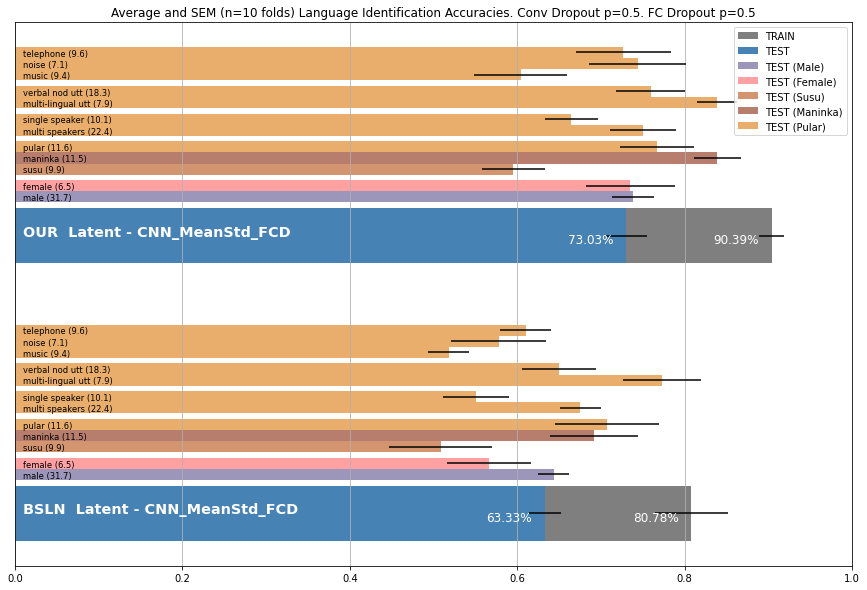

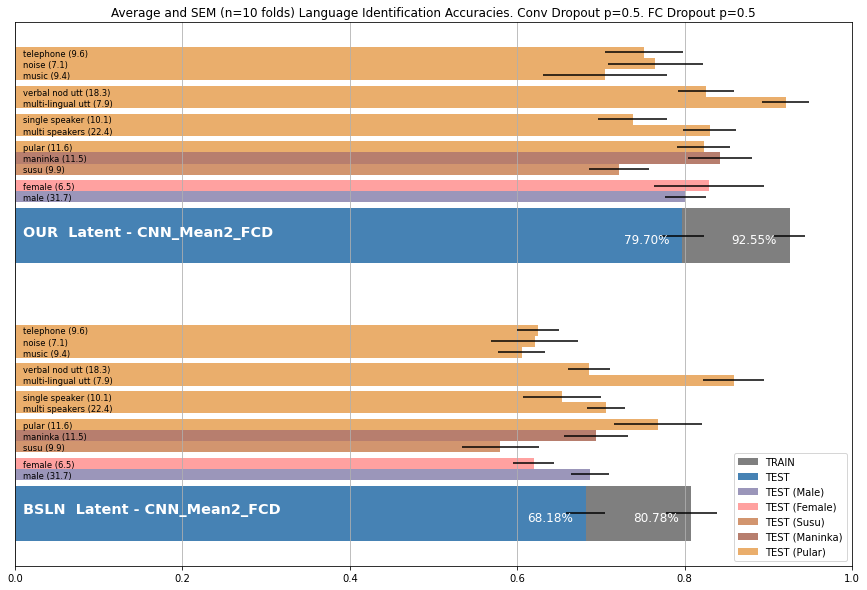

In [13]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    # plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)


# Inspection of problematic audio clips

In [14]:
import csv
import numpy as np
from pathlib import Path
import pydub
import librosa
import librosa.display
import IPython
import IPython.display

In [15]:
CLASS_NAMES = ["maninka", "susu", "pular"]
RESULTS_DIR = 'results_006_gn_lang_classification_error_analysis/LangIdCNN_Mean2'
# RESULTS_FILENAME = "results_006_gn_lang_classification_error_analysis/LangIdCNN_Mean2/wav2vec_features-c_0_data/epoch_1000.csv"
# RESULTS_FILENAME = "results_006_gn_lang_classification_error_analysis/LangIdCNN_Mean2/retrained-wav2vec_features-z_1_data/epoch_1000.csv"
BASE_AUDIO_DIR = "/media/xtrem/data/experiments/nicolingua-0001-language-id/audio_samples"

In [16]:
def np_array_from_str(str_logits):
    return np.array([float(l) for l in str_logits.strip().strip('[').strip(']').split()])

In [17]:
def softmax(logits):
    c_probs = np.exp(logits)
    c_probs = c_probs / np.sum(c_probs)
    c_index = np.argmax(c_probs)
    return c_index, c_probs

In [18]:
def load_test_classifications(results_fname):
    with open(results_fname) as f:
        reader = csv.DictReader(f)
        for datum in reader:
            # print(x.keys()) ['fold_id', 'datum_index', 'datum_name', 'true_class_id', 'logits']
            logits = np_array_from_str(datum['logits'])
            c_index, c_probs = softmax(logits)
            str_cprobs = [f"{p:.2%}" for p in c_probs]

            true_c_index = int(datum['true_class_id'])
            
            test_classification = {
                "datum_name": datum["datum_name"],
                "predicted_c_index": c_index,
                "predicted_c_probs": c_probs,
                "true_c_index": true_c_index,
                "correct_classification": c_index == true_c_index
            }
            
            yield test_classification

In [19]:
def load_all_test_classifications():
    for model_name in model_names:
        for feature_prefix in compared_features_latent:
            best_epochs = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc')
            
            print(f"Best Epochs. {model_name} {feature_prefix} {best_epochs}")
            for fold_id, best_epoch in enumerate(best_epochs):
                results_fname = Path(RESULTS_DIR) / f"{feature_prefix}_{fold_id}_data/epoch_{best_epoch:04}.csv"
                
                for test_classifications in load_test_classifications(results_fname):
                    test_classifications['fold_id'] = fold_id
                    test_classifications['best_epoch'] = best_epoch
                    test_classifications['feature_prefix'] = feature_prefix
                    test_classifications['model_name'] = model_name

                    yield test_classifications


In [20]:
def get_datum_classifications(all_test_classifications, model_name, feature_prefix, datum_name):
    datum_classifications = [
        t for t in all_test_classifications 
        if (t['model_name'], t['feature_prefix'], t['datum_name']) == (model_name, feature_prefix, datum_name)
    ]
    return datum_classifications
    
def get_datum_misclassification_score(all_test_classifications, model_name, feature_prefix, datum_name):
    datum_classifications = get_datum_classifications(all_test_classifications, model_name, feature_prefix, datum_name)
    t_count = len(datum_classifications)
    if t_count>0:
        m_count = len([t for t in datum_classifications if not t['correct_classification']])
        return m_count / t_count
    else:
        return 0
    
def display_datum(all_test_classifications, model_name, feature_prefix, datum_name, dump_dir=None):
    display(HTML(f"<h3>{datum_name}</h3>"))
    for c in get_datum_classifications(all_test_classifications, model_name, feature_prefix, datum_name):
        # {'predicted_c_index': 1, 'predicted_c_probs': array([2.46560180e-01, 7.53422834e-01, 1.69859814e-05]), 'true_c_index': 0, 'correct_classification': False}
        fold_id = c['fold_id']
        correct = "✔️" if c['correct_classification'] else "❌"
        true_class = CLASS_NAMES[c['true_c_index']]
        predicted_class = CLASS_NAMES[c['predicted_c_index']]
        print(f"Fold#{fold_id} {correct}, Class: {true_class}, Predicted: {predicted_class}")
    
    audio_path = Path(BASE_AUDIO_DIR) / datum_name
    display(IPython.display.Audio(audio_path))
    
    
    
    
    plt.figure(figsize=(14, 5))
    #fig, ax = plt.subplots(2, 1, sharex=True)

    x, sr = librosa.load(audio_path)
    
    ax1 = plt.subplot(211)
    display(librosa.display.waveplot(x, sr=sr))
    
    plt.subplot(212, sharex=ax1)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    display(librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz'))
    
    
    if dump_dir:
        Path(f"{dump_dir}").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"{dump_dir}/{datum_name}.png")
        shutil.copy(audio_path, f"{dump_dir}/{datum_name}")
        
        
    plt.show()
    

In [21]:
def compute_frequent_misclassifications(all_test_classifications):
    frequent_misclassifications = {}
    for model_name in model_names:
        for feature_prefix in compared_features_latent:
            datum_with_scores = [
                (
                    datum_name, 
                    get_datum_misclassification_score(all_test_classifications, model_name, feature_prefix, datum_name)
                )
                for datum_name in all_tested_datums
            ]
            datum_with_scores = sorted(datum_with_scores, key=lambda t: t[1], reverse=True)
            datum_with_scores = [t for t in datum_with_scores if t[1]>0.9]

            frequent_misclassifications[(model_name, feature_prefix)] = datum_with_scores
    return frequent_misclassifications

In [22]:
all_test_classifications = list(load_all_test_classifications())
all_tested_datums = sorted({t["datum_name"] for t in all_test_classifications})

frequenty_misclassified_datums = {}
frequent_misclassifications = compute_frequent_misclassifications(all_test_classifications)
    
for (model_name, feature_prefix), datum_with_scores  in frequent_misclassifications.items():
    frequenty_misclassified_datums[(model_name, feature_prefix)] = {d[0] for d in datum_with_scores}
    display(HTML(f"<h3>Frequently Misclassified{model_name}, {feature_prefix}</h3>"))
    for datum, score in datum_with_scores:
        dump_dir = f"dumps/frequent_misclassifications_{model_name}_{feature_prefix}"
        display_datum(all_test_classifications, model_name, feature_prefix, datum, dump_dir)

Best Epochs. LangIdCNN_MeanStd_FCD wav2vec_features-z [626 663 336 376 239 768 879 865 703 506]


FileNotFoundError: [Errno 2] No such file or directory: 'results_006_gn_lang_classification_error_analysis/LangIdCNN_Mean2/wav2vec_features-z_0_data/epoch_0626.csv'

In [ ]:
keys = sorted(frequenty_misclassified_datums.keys())
left_key, right_key = keys[0], keys[1]
            
left_set = frequenty_misclassified_datums[left_key]
right_set = frequenty_misclassified_datums[right_key]

common = left_set.intersection(right_set)

left_only = sorted(left_set - common)
right_only = sorted(right_set - common)

display(HTML(f"<h3>Frequently Misclassified by {left_key} only </h3>"))
print(left_only)
for datum in left_only:
    dump_dir = f"dumps/frequent_misclassifications_{left_key[0]}_{left_key[1]}_only"
    display_datum(all_test_classifications, model_name, left_key[1], datum, dump_dir)

display(HTML(f"<h3>Frequently Misclassified by {right_key} only </h3>"))
print(right_only)
for datum in right_only:
    dump_dir = f"dumps/frequent_misclassifications_{right_key[0]}_{right_key[1]}_only"
    display_datum(all_test_classifications, model_name, right_key[1], datum, dump_dir)
    
display(HTML(f"<h3>Frequently Misclassified by {left_key} and {right_key} only </h3>"))
print(common)
for datum in common:
    dump_dir = f"dumps/frequent_misclassifications_{left_key[0]}_{left_key[1]}__and__{right_key[0]}_{right_key[1]}"
    display_datum(all_test_classifications, model_name, right_key[1], datum, dump_dir)
